# 선형회귀 Linear Regression
* **2학기**로 y = 각 시간별 주문 합계를 확인

### 라이브러리 임포트

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
import pickle

### data 불러오기

In [32]:
df = pd.read_excel("../resource/final_for_models.xlsx")
df.head()

,일자,semester,season,event,day of the week,time,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,0,0,2,8,-2.9,0.6,0.0,78,15
1,2022-03-02,1,0,0,2,9,0.4,1.2,0.0,59,12
2,2022-03-02,1,0,0,2,10,3.6,0.3,0.0,47,18
3,2022-03-02,1,0,0,2,11,5.2,1.3,0.0,42,39
4,2022-03-02,1,0,0,2,12,6.8,1.2,0.0,27,34


In [33]:
df = df.rename(columns = {'day of the week' : '요일', 'season' : '계절', 'semester' : '학기', 'time': 'hour'})   # 보기 편하게 열 이름 rename
df

,일자,학기,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
0,2022-03-02,1,0,0,2,8,-2.9,0.6,0.0,78,15
1,2022-03-02,1,0,0,2,9,0.4,1.2,0.0,59,12
2,2022-03-02,1,0,0,2,10,3.6,0.3,0.0,47,18
3,2022-03-02,1,0,0,2,11,5.2,1.3,0.0,42,39
4,2022-03-02,1,0,0,2,12,6.8,1.2,0.0,27,34
...,...,...,...,...,...,...,...,...,...,...,...
1471,2022-12-21,2,11,2,2,13,0.3,0.8,0.0,89,40
1472,2022-12-21,2,11,2,2,14,0.6,1.0,0.0,88,39
1473,2022-12-21,2,11,2,2,15,2.0,0.1,0.0,83,22
1474,2022-12-21,2,11,2,2,16,0.7,0.5,0.0,89,27


In [34]:
# 2학기만 진행하기 때문에, 학기 열에 mask를 진행

df = df[df['학기'] == 2]
df.drop('학기', axis=1, inplace=True)

C:\Users\sohtk\AppData\Local\Temp\ipykernel_23816\1311148288.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('학기', axis=1, inplace=True)


## Regression 모델에 맞게 데이터 전처리

#### Categorical 데이터들을 Regression 모델이 이해할 수 있는 **One-Hot Encoding**을 통해 binary data로 변환

In [35]:
# one-hot encoding을 위해, 숫자형으로 바꿨던 것을 다시 범주형으로 바꿔줌
# (기존에 정의한 함수 mapping 사용)

from model_prep.onehotmap import *

df = map_season(df, '계절')
df = map_event(df, 'event')
df = map_day(df, '요일')
df = map_hour(df, 'hour')

df.head()  # 바뀐 df 확인

c:\Users\sohtk\OneDrive\desktop\2023-2\ds_python\P4DS_gaeun_allocation\model\model_prep\onehotmap.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].astype(str).replace(season_mapping)
c:\Users\sohtk\OneDrive\desktop\2023-2\ds_python\P4DS_gaeun_allocation\model\model_prep\onehotmap.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df[column_name].astype(str).replace(event_mapping)
c:\Users\sohtk\OneDrive\desktop\2023-2\ds_python\P4DS_gaeun_allocation\

,일자,계절,event,요일,hour,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
726,2022-09-01,가을,평소,목요일,8시,19.4,0.8,0.0,89,28
727,2022-09-01,가을,평소,목요일,9시,21.2,1.5,0.0,81,31
728,2022-09-01,가을,평소,목요일,10시,23.6,0.4,0.0,70,38
729,2022-09-01,가을,평소,목요일,11시,25.2,1.9,0.0,63,102
730,2022-09-01,가을,평소,목요일,12시,26.9,2.0,0.0,57,86


In [36]:
# '계절', 'event', '요일'에 대해 one-hot encoding 수행
data_encoded = pd.get_dummies(df, columns=['계절', 'event', '요일', 'hour'])

data_encoded   # one-hot encoding 잘됐는지 확인

,일자,기온(°C),풍속(m/s),강수량(mm),습도(%),합계,계절_가을,계절_겨울,event_보강주,event_시험,...,hour_10시,hour_11시,hour_12시,hour_13시,hour_14시,hour_15시,hour_16시,hour_17시,hour_8시,hour_9시
726,2022-09-01,19.4,0.8,0.0,89,28,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
727,2022-09-01,21.2,1.5,0.0,81,31,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
728,2022-09-01,23.6,0.4,0.0,70,38,True,False,False,False,...,True,False,False,False,False,False,False,False,False,False
729,2022-09-01,25.2,1.9,0.0,63,102,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
730,2022-09-01,26.9,2.0,0.0,57,86,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,2022-12-21,0.3,0.8,0.0,89,40,False,True,False,True,...,False,False,False,True,False,False,False,False,False,False
1472,2022-12-21,0.6,1.0,0.0,88,39,False,True,False,True,...,False,False,False,False,True,False,False,False,False,False
1473,2022-12-21,2.0,0.1,0.0,83,22,False,True,False,True,...,False,False,False,False,False,True,False,False,False,False
1474,2022-12-21,0.7,0.5,0.0,89,27,False,True,False,True,...,False,False,False,False,False,False,True,False,False,False


#### 일자 없애기
* regression에선 datetime 데이터 타입을 받을 수 없기 때문에 진행해줘야 함
* 슬라이싱 진행

In [37]:
data = data_encoded.iloc[:, 1:]
data

,기온(°C),풍속(m/s),강수량(mm),습도(%),합계,계절_가을,계절_겨울,event_보강주,event_시험,event_축제,...,hour_10시,hour_11시,hour_12시,hour_13시,hour_14시,hour_15시,hour_16시,hour_17시,hour_8시,hour_9시
726,19.4,0.8,0.0,89,28,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
727,21.2,1.5,0.0,81,31,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
728,23.6,0.4,0.0,70,38,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
729,25.2,1.9,0.0,63,102,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
730,26.9,2.0,0.0,57,86,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,0.3,0.8,0.0,89,40,False,True,False,True,False,...,False,False,False,True,False,False,False,False,False,False
1472,0.6,1.0,0.0,88,39,False,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
1473,2.0,0.1,0.0,83,22,False,True,False,True,False,...,False,False,False,False,False,True,False,False,False,False
1474,0.7,0.5,0.0,89,27,False,True,False,True,False,...,False,False,False,False,False,False,True,False,False,False


#### 데이터프레임 보기 좋게 정렬

In [38]:
data.columns    # 해당 데이터프레임의 columns가 뭐가 있는지 확인하기 위함

Index(['기온(°C)', '풍속(m/s)', '강수량(mm)', '습도(%)', '합계', '계절_가을', '계절_겨울',
       'event_보강주', 'event_시험', 'event_축제', 'event_평소', '요일_금요일', '요일_목요일',
       '요일_수요일', '요일_월요일', '요일_화요일', 'hour_10시', 'hour_11시', 'hour_12시',
       'hour_13시', 'hour_14시', 'hour_15시', 'hour_16시', 'hour_17시', 'hour_8시',
       'hour_9시'],
      dtype='object')

In [39]:
# 보기 쉬운 열 정렬로 직접 정렬해줌

data = data[['hour_8시', 'hour_9시', 'hour_10시', 'hour_11시', 'hour_12시', 
             'hour_13시', 'hour_14시', 'hour_15시', 'hour_16시', 'hour_17시', 
             '계절_가을', '계절_겨울', 'event_보강주', 'event_시험', 'event_축제', 'event_평소',
             '요일_월요일', '요일_화요일', '요일_수요일', '요일_목요일', '요일_금요일', 
             '기온(°C)', '풍속(m/s)', '강수량(mm)', '습도(%)', '합계']]

data.head()  # 정렬 모습 확인

,hour_8시,hour_9시,hour_10시,hour_11시,hour_12시,hour_13시,hour_14시,hour_15시,hour_16시,hour_17시,...,요일_월요일,요일_화요일,요일_수요일,요일_목요일,요일_금요일,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
726,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,19.4,0.8,0.0,89,28
727,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,21.2,1.5,0.0,81,31
728,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,23.6,0.4,0.0,70,38
729,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,25.2,1.9,0.0,63,102
730,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,26.9,2.0,0.0,57,86


In [40]:
# one-hot encoding을 진행해줬던 열들의 이름이 '(one-hot encode 당한 열의 이름)_(해당 열의 속성값)'으로 구성되어있음
# 가독성을 위해, '(해당 열의 속성값)'만 남겨두고 언더바부터 앞의 문자까지 삭제해주는 전처리 진행

# 미리 지정해둔 함수를 통해 전처리
from model_prep.dfrename import *

check = rename_columns(data)
check.head()

,8시,9시,10시,11시,12시,13시,14시,15시,16시,17시,...,월요일,화요일,수요일,목요일,금요일,기온(°C),풍속(m/s),강수량(mm),습도(%),합계
726,True,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,19.4,0.8,0.0,89,28
727,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,21.2,1.5,0.0,81,31
728,False,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,23.6,0.4,0.0,70,38
729,False,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,25.2,1.9,0.0,63,102
730,False,False,False,False,True,False,False,False,False,False,...,False,False,False,True,False,26.9,2.0,0.0,57,86


## Regression 전, 변수들의 correlation 분석
* **히트맵**을 사용해 **상관관계**를 시각화

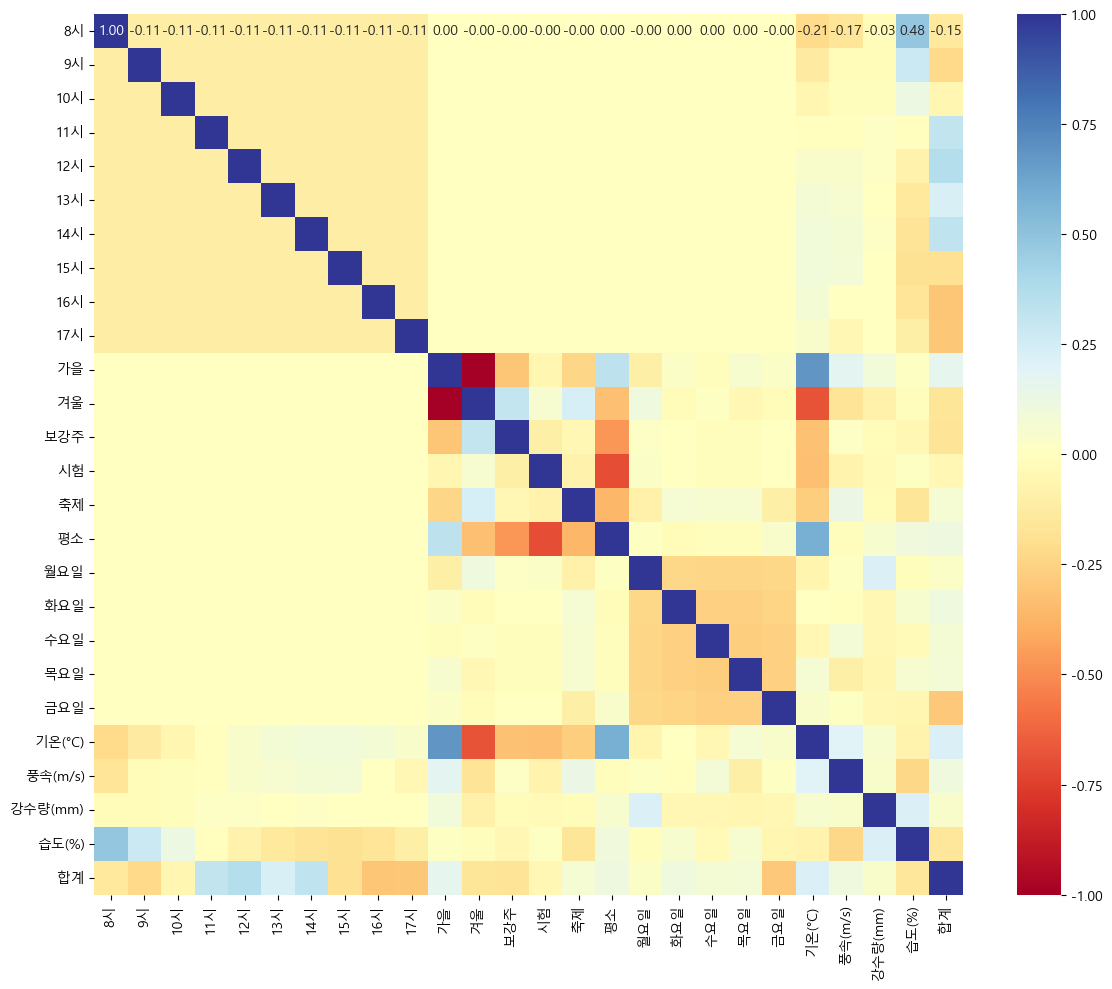

In [41]:
# 미리 지정해둔 함수를 통해 히트맵으로 시각화
from vis.corrvis import corr_heatmap

corr = data.corr(method = 'pearson')
cols = list(data.columns)
corr_heatmap(corr, cols)

## Linear Regression 진행

#### X와 y 지정

In [42]:
num_cols = cols
num_cols.remove('합계')   # 데이터프레임 전체의 columns를 리스트로 받아왔었기 때문에, y로 들어갈 '합계'를 제거

X = data[num_cols]
y = data["합계"]

### Linear Regression Experiment
1. **임의로 랜덤**하게 test셋과 train셋을 나눔
* **각 변수가 얼만큼 영향**을 미치는지 확인 _(= 가중치 뽑기)_ 해보기 위해 진행

In [43]:
train_input, test_input, train_target, test_target = train_test_split(X, y, random_state=42)
# random_state: 호출할 때마다 동일한 train/test dataset을 생성하기 위해 주어지는 parameter

In [44]:
# linear regression 모델 호출 및 fit

lr = LinearRegression()
lr.fit(train_input, train_target)

LinearRegression()

In [45]:
# coef_ = 가중치 리스트, intercept_ = 회귀식의 상수

print(lr.coef_, lr.intercept_)

[ -4.54672832 -12.65244101  -3.16017346  23.27427952  26.25928733
  15.86657264  22.17034193 -16.73856856 -26.28239348 -24.1901766
   1.2432934   -1.2432934  -10.55533094  -0.08092399   9.59918203
   1.0370729    2.27346359   5.50033853   3.53002006   3.67378229
 -14.97760447   0.31646831  -0.10967117   1.02420299  -0.11038866] 44.40602918007131


* 학습시킨 모델의 지표를 확인

In [46]:
# test set으로 예측
pred_test = lr.predict(test_input)  # X_test 데이터를 예측한 결과 저장

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 평가 지표 계산
mae = mean_absolute_error(test_target, pred_test)
mse = mean_squared_error(test_target, pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(test_target, pred_test)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared:", r2)

Mean Absolute Error (MAE): 10.111962766483558
Mean Squared Error (MSE): 158.8040101895984
Root Mean Squared Error (RMSE): 12.601746315078652
R-squared: 0.735779215492234


#### 각 변수들의 **가중치** 확인
* 해당 모델의 가중치를 dataframe에 넣음

In [48]:
### "feature - coefficients" DataFrame 만들기
coefs = pd.DataFrame(zip(data[num_cols].columns, lr.coef_), columns = ['feature', 'coefficients'])

# 절댓값을 기준으로 정렬하기 위한 임시 열 추가
coefs['abs_coef'] = coefs['coefficients'].abs()

# 'abs_coef' 열을 기준으로 오름차순 정렬
# 오름차순 정렬을 해야, 시각화했을 때 가장 영향을 많이 주는 것이 가장 위로 보이며 시각화가 됨
coefs.sort_values(by='abs_coef', inplace=True)

coefs.head(7)   # 확인

,feature,coefficients,abs_coef
13,시험,-0.080924,0.080924
22,풍속(m/s),-0.109671,0.109671
24,습도(%),-0.110389,0.110389
21,기온(°C),0.316468,0.316468
23,강수량(mm),1.024203,1.024203
15,평소,1.037073,1.037073
10,가을,1.243293,1.243293


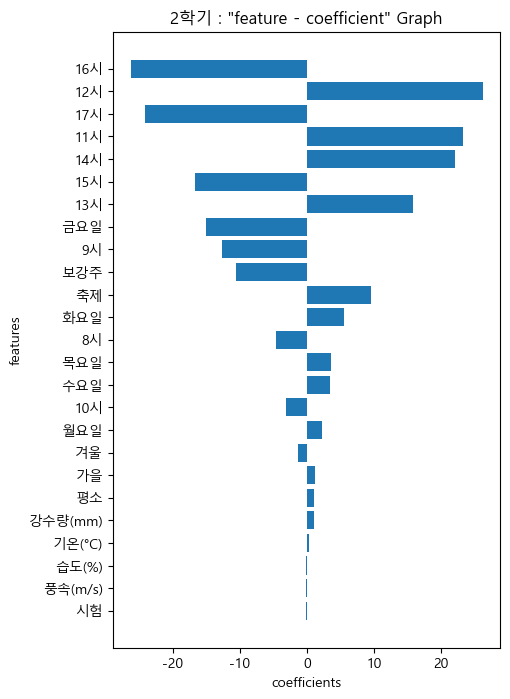

In [49]:
### coefficients 를 시각화

### figure size
plt.figure(figsize=(5, 8))

### bar plot : matplotlib.pyplot 모듈의 barh() 함수를 사용해서 수평 막대 그래프를 그림
plt.barh(coefs['feature'], coefs['coefficients'])
plt.title('2학기 : "feature - coefficient" Graph')
plt.xlabel('coefficients')
plt.ylabel('features')
plt.show()

In [50]:
# 파일로 저장
plt.savefig('../visualization/png/reg_feature_coef_2nd.png', dpi=300)

<Figure size 640x480 with 0 Axes>

2. 모델이 **general**한지 알아보기 위해 **K-Fold Cross Validation**을 진행

In [51]:
# K-Fold Cross Validation 설정
# 5겹으로 진행
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lr = LinearRegression()


# 교차 검증을 통한 모델 학습 및 평가
r2_scores = cross_val_score(lr, X, y, scoring='r2', cv=kf)
mse_scores = cross_val_score(lr, X, y, scoring='neg_mean_squared_error', cv=kf)
mae_scores = cross_val_score(lr, X, y, scoring='neg_mean_absolute_error', cv=kf)


# 평균 성능 지표 계산
aver_r2 = r2_scores.mean()     # 평균 R2 값 계산

mse = np.mean(np.abs(mse_scores))  # 평균 MSE 값 계산
rmse = np.sqrt(mse)  # RMSE 값 계산

mae = np.mean(np.abs(mae_scores))  # 평균 MAE 값 계산


# 결과 출력
print("Average R² Score:", aver_r2)
print("Average MSE:", mse)
print("Average RMSE:", rmse)
print("Average MAE:", mae)

Average R² Score: 0.745286946293847
Average MSE: 156.0645676398397
Average RMSE: 12.492580503636537
Average MAE: 9.474127304117392


3. 각 **변수가 유효**한지 확인을 위해, 통계 라이브러리 선형회귀를 돌려 **OLS Summary** 호출
* R-Squared, t value 확인

In [21]:
import statsmodels.api as sm

X_train2 = sm.add_constant(train_input) # formatting
### 회귀분석모형 수식을 간단하게 만들기 위해 다음과 같이 상수항을 독립변수 데이터에 추가하는 것을 상수항 결합(bias augmentation)작업이라고 함

### ordinary least square 의 약자로, 거리의 최소값을 기준으로 구하는 함수
### 상수항이 추가된 독립변수와 그에 대한 y 값으로 학습함
model2 = sm.OLS(train_target, X_train2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     합계   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     85.54
Date:                Tue, 05 Dec 2023   Prob (F-statistic):          1.91e-156
Time:                        21:00:32   Log-Likelihood:                -2191.9
No. Observations:                 562   AIC:                             4428.
Df Residuals:                     540   BIC:                             4523.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6615      1.227     17.648      0.000      19.250      24.073
8시            -2.3806      2.189     -1.088      0.277      -6.680       1.919
9시           -10.4863      1.785     -5.876      0.000     -13.992      -6.981
10시           -0.9940      1.643     -0.605      0.545      -4.221       2.233
11시           25.4404      1.528     16.646      0.000      22.438      28.443
12시           28.4254      1.555     18.283      0.000      25.371      31.480
13시           18.0327      1.607     11.221      0.000      14.876      21.190
14시           24.3365      1.637     14.868      0.000      21.121      27.552
15시          -14.5724      1.588     -9.176      0.000     -17.692     -11.453
16시          -24.1162      1.666    -14.475      0.000     -27.389     -20.844
17시          -22.0240      1.557    -14.146      0.000     -25.082     -18.966
가을            12.0740      1.084     11.140      0.000       9.945      14.203
겨울             9.5874      0.928     10.333      0.000       7.765      11.410
보강주           -5.1400      1.736     -2.960      0.003      -8.551      -1.729
시험             5.3344      1.469      3.630      0.000       2.448       8.221
축제            15.0146      2.247      6.682      0.000      10.601      19.428
평소             6.4524      1.313      4.914      0.000       3.873       9.032
월요일            6.6058      1.160      5.693      0.000       4.327       8.885
화요일            9.8326      1.096      8.975      0.000       7.681      11.985
수요일            7.8623      1.052      7.476      0.000       5.797       9.928
목요일            8.0061      1.069      7.493      0.000       5.907      10.105
금요일          -10.6453      1.044    -10.193      0.000     -12.697      -8.594
기온(°C)         0.3165      0.103      3.073      0.002       0.114       0.519
풍속(m/s)       -0.1097      0.722     -0.152      0.879      -1.527       1.308
강수량(mm)        1.0242      0.751      1.364      0.173      -0.450       2.499
습도(%)         -0.1104      0.039     -2.804      0.005      -0.188      -0.033
==============================================================================
Omnibus:                       96.805   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              355.504
Skew:                           0.753   Prob(JB):                     6.36e-78
Kurtosis:                       6.593   Cond. No.                     1.06e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.81e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

* 겨울, 풍속, 강수량이 t value가 0.05보다 높게 나옴.

In [22]:
# 모델 요약 결과를 문자열로 변환
summary_str = model2.summary().as_text()

# 문자열을 DataFrame으로 변환
summary_df = pd.DataFrame([summary_str.split('\n')])

# 엑셀 파일로 저장
summary_df.to_excel("OLS_summary.xlsx", index=False)

### 예측 결과 시각화 (test set)

In [52]:
### 예측 결과 시각화 (test set)
df = pd.DataFrame({'actual': test_target, 'prediction': pred_test})
df = df.sort_values(by='actual').reset_index(drop=True)
df.head()

,actual,prediction
0,5,31.237286
1,8,3.501291
2,9,3.025565
3,9,16.507764
4,10,21.408608


In [53]:
df.tail()

,actual,prediction
183,97,71.191348
184,99,74.056580
185,100,77.644417
186,101,77.076060
187,108,74.806806


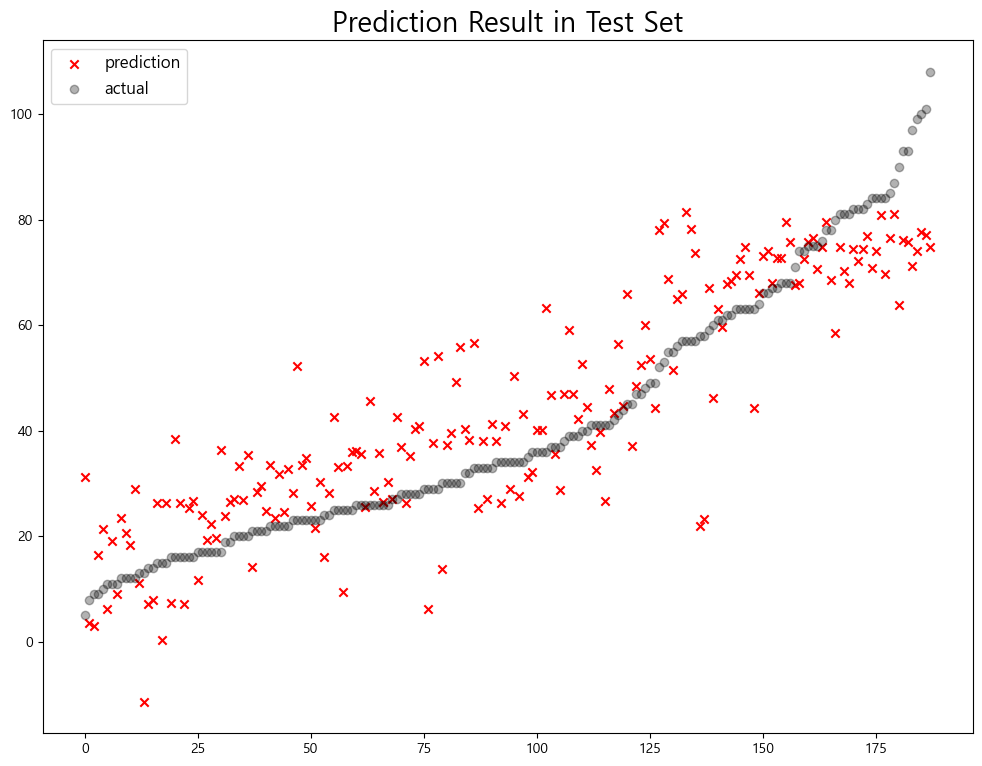

In [54]:
plt.figure(figsize=(12, 9))
plt.scatter(df.index, df['prediction'], marker='x', color='r')
plt.scatter(df.index, df['actual'], alpha=0.3, marker='o', color='black')
plt.title("Prediction Result in Test Set", fontsize=20)
plt.legend(['prediction', 'actual'], fontsize=12)
plt.show()

### 학습시킨 모델 저장

In [55]:
# 모델 저장
with open('../run/model_load/reg_2nd.pkl', 'wb') as file:
    pickle.dump(lr, file)